# Price per square meter as a function of apartment size in the Finnish real-estate market

Based on browsing apartment ads it seems that small apartments are more expensive per square meter than larger apartments. I wanted to find out if this is true, and quantify the results.

The data is scraped from https://asuntojen.hintatiedot.fi/haku/.

## Part 1: Gathering data

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [24]:
#TODO

# 1. Avoid '\xa0 in parsing'
# 2. Random forest not great for lots of OH-encoded values. Try LightGBM and/or XGBOOST
# 3. Cat boost for categorical variables?

In [3]:
def parse_website(postal_code):
    '''
    Connects to asuntojen.hintatiedot.fi and pulls data on sold apartments from the last 12 months.
    
    
    Parameters:
    postal_code (str): Postal area code to get data for
    
    Returns:
    Nested list with apartment data
    
    '''
    URL = 'https://asuntojen.hintatiedot.fi/haku/?c=&cr=1&ps=' + postal_code + '&nc=0&amin=&amax=&renderType=renderTypeTable&search=1'
    
    page = requests.get(URL)

    soup = BeautifulSoup(page.content, 'html.parser')

    main_table = soup.find(id='mainTable')

    apartments = main_table.find_all('tr', class_="")
    
    
    local_area_apartments = []
    for a in apartments[4:-2]: # First 4 and last 2 'td' tags are not apartment information
        elements = a.find_all('td')

        parsed_apartment = [element.text.replace("\xa0", "") for element in elements]
        
        if len(parsed_apartment) < 2:
            continue
        parsed_apartment[3] = parsed_apartment[3].replace(",", ".") #Change to international decimal delimiter
        #parsed_apartment[9] = parsed_apartment[9].replace("\xa0", "") #Change to international decimal delimiter
        parsed_apartment[10] = parsed_apartment[10].split("\t")[0] #Weird formatting in source website
        parsed_apartment.append(postal_code)
        local_area_apartments.append(parsed_apartment)
        
    return local_area_apartments
    

In [4]:
parsed_apartments = []
postal_codes = ['00'+str(10*i) for i in range(10,100)] #All Helsinki postal codes

count = 0
for postal_code in postal_codes:
    apartments = parse_website(postal_code)
    for apartment in apartments:
        parsed_apartments.append(apartment)
    if count%10 == 0:
        print(f"Parsed {count}/{len(postal_codes)} postal codes")
    count += 1
print("Parsed all postal codes")

Parsed 0/90 postal codes
Parsed 10/90 postal codes
Parsed 20/90 postal codes
Parsed 30/90 postal codes
Parsed 40/90 postal codes
Parsed 50/90 postal codes
Parsed 60/90 postal codes
Parsed 70/90 postal codes
Parsed 80/90 postal codes
Parsed all postal codes


In [5]:
columns = ['neighborhood', 'apartment_type', 'house_type', 'sqm', 'price', 'price_per_sqm', 'year_built', 'floor', 'elevator', 'condition', 'plot_ownership', 'energy_class', 'postal_code']
df = pd.DataFrame(parsed_apartments,columns=columns)

to_numeric_columns = ['sqm', 'price', 'price_per_sqm', 'year_built']
for column in to_numeric_columns:
    df[column] = pd.to_numeric(df[column])

#Outputting data to .csv file in order to save data and avoid the need to pull data again
df.to_csv("apartment_prices.csv")

In [6]:
df.head()

,neighborhood,apartment_type,house_type,sqm,price,price_per_sqm,year_built,floor,elevator,condition,plot_ownership,energy_class,postal_code
0,Etu-töölö,"1h, avok, kph, kht",kt,24.0,217000,9042,1929,6/7,on,hyvä,oma,E2018,00100
1,Etu-töölö,"1h, kk",kt,28.0,260000,9286,1927,1/6,on,tyyd.,oma,F2013,00100
2,Etu-töölö,1h+k,kt,41.0,320000,7805,1911,2/5,ei,hyvä,oma,E2018,00100
3,Töölö,"1h,ikk.kk,kh",kt,23.0,226000,9826,1934,1/3,ei,tyyd.,oma,D2013,00100
4,Keskusta,"1h,k",kt,47.9,500000,10438,1905,3/3,ei,tyyd.,oma,G,00100


## Part 2: Simple prediction solution including data preprocessing

In [7]:
# We will use house type, sqm, price, year_built, floor, elevator, condition, plot_ownership and postal_code
# To predict the price_per_sqm
cols = ['price_per_sqm','house_type', 'sqm', 'price', 'year_built', 'floor', 'elevator', 'condition', 'plot_ownership', 'postal_code']
df_ml = df[cols].copy(deep=True)
df_ml.replace('', np.nan, inplace=True)


#Find columns with missing values
columns_with_missing_values = [col for col in df_ml.columns if df_ml[col].isna().any()]

for col in columns_with_missing_values:
    print(f"Count of values in column {col} = {df_ml[df_ml[col].isna()].index.size}")

#As the count of rows containing missing values is somewhat low, the corresponding rows are dropped
df_ml.dropna(axis=0, inplace=True)

Count of values in column floor = 26
Count of values in column condition = 28
Count of values in column plot_ownership = 21


In [8]:
# We will use house type, sqm, price, year_built, floor, elevator, condition, plot_ownership and postal_code
# To predict the price_per_sqm

def parse_floor(row):
    '''
    Converts the string describing current and total floors to usable features.
    '''
    floors = row['floor'].split('/')
    try:
        row['floors'] = float(floors[1])
        row['current_floor'] = float(floors[0])
        row['floor_ratio'] = float(floors[0])/float(floors[1])
    except:
        pass
    return row

df_ml['floors'] = pd.Series()
df_ml['current_floor'] = pd.Series()
df_ml['floor_ratio'] = pd.Series()

df_ml = df_ml.apply(parse_floor, axis='columns')

features = df_ml.drop(['price_per_sqm', 'floor', 'price'], axis=1)
labels = df_ml['price_per_sqm']

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, random_state=0) 

In [37]:
features_train

,house_type,sqm,year_built,elevator,condition,plot_ownership,postal_code,floors,current_floor,floor_ratio
1798,kt,70.5,1971,ei,hyvä,oma,00720,3.0,3.0,1.000000
232,kt,45.5,1926,ei,hyvä,oma,00170,4.0,4.0,1.000000
513,kt,36.0,1927,on,hyvä,oma,00260,6.0,3.0,0.500000
2437,kt,55.5,2019,ei,hyvä,oma,00940,2.0,2.0,1.000000
866,kt,44.6,1973,ei,hyvä,vuokra,00400,6.0,6.0,1.000000
...,...,...,...,...,...,...,...,...,...,...
1768,rt,50.5,1989,ei,hyvä,oma,00720,1.0,1.0,1.000000
774,kt,64.5,1973,ei,hyvä,oma,00370,5.0,5.0,1.000000
849,kt,26.0,1954,on,hyvä,vuokra,00400,6.0,5.0,0.833333
1688,rt,80.0,2020,ei,hyvä,vuokra,00700,2.0,1.0,0.500000


In [38]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor

numerical_cols = ['sqm', 'year_built', 'floors', 'current_floor']
ordinal_cols = ['elevator', 'condition', 'plot_ownership']
categorical_cols = ['house_type', 'postal_code']

ordinal_transformer = Pipeline(steps=[('ordinal', OrdinalEncoder())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
minmax_scaler = Pipeline(steps=[('minmax', MinMaxScaler(feature_range=(0,1)))])

preprocessor = ColumnTransformer(
    transformers = [
        ('ord', ordinal_transformer, ordinal_cols),
        ('cat', categorical_transformer, categorical_cols),
        ('minmax', minmax_scaler, numerical_cols)
    ])


random_forest = RandomForestRegressor(n_estimators=100)
random_forest_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('model', random_forest)])
random_forest_pipeline.fit(features_train, labels_train)

score = cross_val_score(random_forest_pipeline, features_train, labels_train, cv=5, scoring='MAE')
print(score)

[0.86405092 0.8419502  0.8587428  0.87511634 0.8799048 ]


## Part n: Below testing, unfinished parts

In [33]:
parameters = {'model__n_estimators': [40, 60, 80, 100, 120, 140, 160, 180]}
CV = GridSearchCV(my_pipeline, parameters, scoring = 'r2', cv=5)
CV.fit(features_train, labels_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('ord',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('ordinal',
                                                                                          OrdinalEncoder(categories='auto',
                                                                                                         dtype=<class 'numpy.float64'>))

In [11]:
CV.best_params_

{'model__n_estimators': 160}

In [12]:
# Feature importances
print(sorted(zip(map(lambda x: round(x, 4), model.feature_importances_), features_train.columns), reverse=True))

[(0.18, 'house_type'), (0.1473, 'year_built'), (0.0397, 'sqm'), (0.0286, 'floor_ratio'), (0.0263, 'elevator'), (0.026, 'floors'), (0.0238, 'postal_code'), (0.0099, 'current_floor'), (0.001, 'plot_ownership'), (0.0006, 'condition')]


In [40]:
# Example apartments for fun

known_apts = {'house_type' : ['kt', 'rt'],
        'sqm': [42, 75],
        'year_built': [1927, 2019],
        'elevator': ['on', 'ei'],
        'condition': ['hyvä', 'hyvä'],
        'plot_ownership':['oma', 'vuokra'],
        'postal_code':['00100', '02740'],
        'floors':[7, 2],
        'current_floor':[3, 2],
        'floor_ratio':[3/7, 1]}

known_apartments = pd.DataFrame.from_dict(known_apts)

my_pipeline.predict(known_apartments)

array([8805.36634052, 3662.08333333])

Text(0, 0.5, 'Cost per sqm')

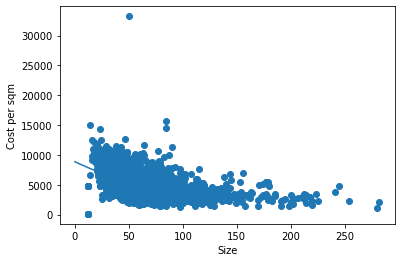

In [16]:
x = df.sqm.astype(float)
y = df.price_per_sqm.astype(float)
z = np.polyfit(x, y, 2)
p = np.poly1d(z)
s = np.linspace(0,160)

plt.scatter(x, y)
plt.plot(s, p(s))
plt.xlabel('Size')
plt.ylabel('Cost per sqm')

## Testing LightGBM
Note: Can work also with categorical variables

In [39]:
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor()


lgbm_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('model', lgbm)])

lgbm_pipeline.fit(features_train, labels_train)

lgbm_score = cross_val_score(my_pipeline2, features_train, labels_train, cv=5, scoring='r2')

lgbm_score

array([0.71315697, 0.65532398, 0.72219894, 0.6886224 , 0.6823448 ])